# Synthetic benchmark plots (Figure 2)


## Before you start

This notebook assumes that the synthetic analysis (small, ten taxa) are already done and metrics have been computed, up to and including `evaluate.sh` has been run. Refer to the README for the `synthetic` analysis pipeline (`scripts/synthetic`) for more details.

The data are expected to be in `../datasets/synthetic`.

The plotting code in the last cell may output some warnings from matplotlib. These are (as of matplotlib 3.7.1) safe to ignore.

In [1]:
from pathlib import Path
import argparse
from typing import List, Dict

import numpy as np
import scipy.integrate
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sb
import pandas as pd
import itertools
from statsmodels.stats.multitest import fdrcorrection

# Make font editable in AI
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

print("Matplotlib version: {}".format(matplotlib.__version__))

Matplotlib version: 3.5.3


In [26]:
# P value tests (with seaborn's boxplot locations)
def perform_tests(df: pd.DataFrame, methods: List[str], y='Error'):
    entries = []
    for (x1, m1), (x2, m2) in itertools.combinations(enumerate(methods), 2):
        if not m1.startswith("MDSINE") and not m2.startswith("MDSINE"):
            continue
        _x = df.loc[df['Method'] == m1, :].sort_values(by=['ReadDepth', 'NoiseLevel', 'Trial'])[y].to_numpy()
        _y = df.loc[df['Method'] == m2, :].sort_values(by=['ReadDepth', 'NoiseLevel', 'Trial'])[y].to_numpy()
        _k = (~np.isnan(_x)) & (~np.isnan(_y))
        _x = _x[_k]
        _y = _y[_k]
        _stat, _pval = scipy.stats.wilcoxon(_x, _y, alternative='two-sided')
        entries.append({
            'Method1': m1,
            'Method2': m2,
            'Median1': np.median(_x),
            'Median2': np.median(_y),
            'MedianDiff': np.median(_x - _y),
            'x1': x1,
            'x2': x2,
            'p': _pval,
            'statistic': _stat,
        })
    pval_df = pd.DataFrame(entries)
    _, bh_pvals = fdrcorrection(pval_df['p'])
    pval_df['bh'] = bh_pvals
    
    return pval_df


def save_pval_df(pval_df: pd.DataFrame, out_path: Path):
    pval_df[['Method1', 'Method2', 'bh', 'statistic', 'p']].rename(columns={
        'Method1': 'Method A',
        'Method2': 'Method B',
        'p': 'p',
        'bh': 'BHCorrectedp',
        'statistic': 'WilcoxonStatistic',
    }).to_csv(out_path, index=False)
    

def annot_pvalues(pval_df: pd.DataFrame, ax, log_scale, y_annot, dh=1.0, h=0.05):
    j = 0
    for idx, row in pval_df.iterrows():
        if row['bh'] > 0.05:
            c = '#FA8072'
            lbl = 'ns'
        elif row['bh'] > 0.01:
            c = 'black'
            lbl = '*'
        elif row['bh'] > 0.001:
            c = 'black'
            lbl = '**'
        elif row['bh'] > 0.0001:
            c = 'black'
            lbl = '***'
        else:
            c = 'black'
            lbl = '****'
            
        if log_scale:
            y = np.power(10, np.log10(y_annot) + dh * j)
        else:
            y = y_annot + dh * j
        annot_pvalue_single(ax, row['bh'], 
                            x1=row['x1'], x2=row['x2'], 
                            y=y, 
                            h=h, color=c, text_label=lbl,
                            log_scale=log_scale)    
        j += 1

    
def annot_pvalue_single(ax, pvalue, x1, x2, y, h, color='black', log_scale=False, text_label=None):
    """ statistical annotation """
    grid_x = np.array([x1, x1, x2, x2])
    grid_y = np.array([0.5*h, 1.5*h, 1.5*h, 0.5*h])
    if log_scale:
        grid_y = np.power(10, np.log10(y) + grid_y)
    else:
        grid_y = y + grid_y
    ax.plot(grid_x, grid_y, lw=0.7, c=color)
    
    if text_label is not None:
        text_x = 0.5 * (x1 + x2)
        if log_scale:
            text_y = np.power(10, np.log10(y) + 0.2 * h)
        else:
            text_y = y + 0.2 * h
        t = ax.text(
            text_x, text_y, text_label, ha='center', va='bottom', color=color, size=10.,
        )

In [27]:
def load_df(df_path: Path) -> pd.DataFrame:
    df = pd.read_csv(df_path, index_col=0)
    df['NoiseLevel'] = pd.Categorical(
        df['NoiseLevel'],
        categories=['low', 'medium', 'high']
    )
    df = df.sort_values(['ReadDepth', 'NoiseLevel'], ascending=[True, True])
    df = df.loc[df['NoiseLevel'] == 'medium']
    return df


def render_growth_rate_errors(df: pd.DataFrame, ax, order, palette):
    if df.shape[0] > 0:
        sb.boxplot(
            data=df,
            x='Method', y='Metric', order=order, palette=palette,
            ax=ax,
            showfliers=False,
            whis=(2.5, 97.5),
            boxprops=dict(edgecolor='black', linewidth=1),         # Box outline
            medianprops=dict(color='black', linewidth=1),           # Median line
            whiskerprops=dict(color='black', linewidth=1),  # Whiskers
            capprops=dict(color='black', linewidth=1)            # Caps
        )
        sb.stripplot(
            data=df,
            x='Method', y='Metric', order=order, palette=palette,
            ax=ax,
            linewidth=1.0,
            edgecolor='black',
            alpha=0.7
        )
    ax.set_ylabel('Cosine-Sim')
    ax.set_xlabel(None)
    # ax.set_yscale('log')
    ax.set_title('Growth Rates')
    ax.legend([], [], frameon=False)
    
    pval_df = perform_tests(df, order, y='Metric')
    y_annot = 1.03 * np.quantile(df['Metric'].dropna(), q=0.99)
    annot_pvalues(pval_df, ax, log_scale=False, y_annot=y_annot, dh=0.08, h=0.01)
    return pval_df


def render_interaction_strength_errors(df: pd.DataFrame, ax, order, palette):
    df['x'] = 0
    if df.shape[0] > 0:
        sb.boxplot(
            data=df,
            x='Method', y='Metric', order=order, palette=palette,
            ax=ax,
            showfliers=False,
            whis=(2.5, 97.5),
            boxprops=dict(edgecolor='black', linewidth=1),         # Box outline
            medianprops=dict(color='black', linewidth=1),           # Median line
            whiskerprops=dict(color='black', linewidth=1),  # Whiskers
            capprops=dict(color='black', linewidth=1)            # Caps
        )
        sb.stripplot(
            data=df,
            x='Method', y='Metric', order=order, palette=palette,
            ax=ax,
            linewidth=1.0,
            edgecolor='black',
            alpha=0.7
        )
    ax.set_ylabel('Cosine-Sim')
    ax.set_xlabel(None)
    # ax.set_yscale('log')
    ax.set_title('Interaction Strengths')
    ax.legend([], [], frameon=False)

    pval_df = perform_tests(df, order, y='Metric')
    y_annot = 1.03 * np.quantile(df['Metric'].dropna(), q=0.99)
    annot_pvalues(pval_df, ax, log_scale=False, y_annot=y_annot, dh=0.09, h=0.015)
    return pval_df


def render_topology_errors(df: pd.DataFrame, ax, order, palette):
    noise_ordering = df['NoiseLevel'].map({
        'low': 0,
        'medium': 1,
        'high': 2
    })
    df = df.assign(Ordering=noise_ordering).sort_values('Ordering')
    df['x'] = 0
    # df.loc[:, 'x'] = df['Method'].map({m: str(i) for i, m in enumerate(order)})
    # palette = {str(i): palette[m] for i, m in enumerate(order)}

    if df.shape[0] > 0:
        sb.boxplot(
            data=df,
            x='Method', y='AUROC', order=order, palette=palette,
            ax=ax,
            showfliers=False,
            whis=(2.5, 97.5),
            boxprops=dict(edgecolor='black', linewidth=1),         # Box outline
            medianprops=dict(color='black', linewidth=1),           # Median line
            whiskerprops=dict(color='black', linewidth=1),  # Whiskers
            capprops=dict(color='black', linewidth=1)            # Caps
        )
        sb.stripplot(
            data=df,
            x='Method', y='AUROC', order=order, palette=palette,
            ax=ax,
            linewidth=1.0,
            edgecolor='black',
            alpha=0.7
        )
    ax.set_ylabel('AUC-ROC')
    ax.set_xlabel(None)
    ax.set_title('Network Structure')
    ax.legend([], [], frameon=False)
    
    pval_df = perform_tests(df, order, y='AUROC')
    y_annot = 1.03 * np.quantile(df['AUROC'].dropna(), q=0.99)
    annot_pvalues(pval_df, ax, log_scale=False, y_annot=y_annot, dh=0.06, h=0.01)
    return pval_df


def render_fwsim_errors(df: pd.DataFrame, ax, order, palette):
    noise_ordering = df['NoiseLevel'].map({
        'low': 0,
        'medium': 1,
        'high': 2
    })
    df = df.assign(Ordering=noise_ordering).sort_values('Ordering')
    df['x'] = 0
    if df.shape[0] > 0:
        sb.boxplot(
            data=df,
            x='Method', y='Metric', order=order, palette=palette,
            ax=ax,
            showfliers=False,
            whis=(2.5, 97.5),
            boxprops=dict(edgecolor='black', linewidth=1),         # Box outline
            medianprops=dict(color='black', linewidth=1),           # Median line
            whiskerprops=dict(color='black', linewidth=1),  # Whiskers
            capprops=dict(color='black', linewidth=1)            # Caps
        )
        sb.stripplot(
            data=df,
            x='Method', y='Metric', order=order, palette=palette,
            ax=ax,
            linewidth=1.0,
            edgecolor='black',
            alpha=0.7
        )
    ax.set_ylabel('RMSLE')
    ax.set_xlabel(None)
    ax.set_title('Forecasting')
    ax.legend([], [], frameon=False)
    
    pval_df = perform_tests(df, order, y='Metric')
    y_annot = 1.03 * np.quantile(df['Metric'].dropna(), q=0.99)
    annot_pvalues(pval_df, ax, log_scale=False, y_annot=y_annot, dh=0.08, h=0.01)
    return pval_df


def render_all(fig: plt.Figure, dataframe_dir: Path, method_order: List[str], palette: Dict[str, np.ndarray], read_depth: int):

    # fig, axes = plt.subplots(1, 4, figsize=figsize)
    # fig = plt.figure(figsize=(16, 10), constrained_layout=True)
    # spec = fig.add_gridspec(ncols=4, nrows=4, height_ratios=[1, 10, 1, 10], width_ratios=[1, 1, 1, 1])

    # ax0 = fig.add_subplot(spec[0, :2])
    # ax1, ax2 = fig.add_subplot(spec[1, 0]), fig.add_subplot(spec[1, 1])

    # spec = fig.add_gridspec(ncols=4, nrows=1, width_ratios=[1, 1, 1, 0.08], wspace=0.9)
    # axes = [fig.add_subplot(spec[0, i]) for i in range(3)]
    
    # axes = fig.subplots(1, 3)
    
    gs = fig.add_gridspec(ncols=4, nrows=1, width_ratios=[1, 1, 1, 1], wspace=0.6)
    axes = [ fig.add_subplot(gs[0,i]) for i in range(4) ]
    
    df = load_df(dataframe_dir / "growth_rate_metrics.csv")
    section = df.loc[df['ReadDepth'] == read_depth]
    pvals = render_growth_rate_errors(
        section,
        ax=axes[0],
        order=method_order,
        palette=palette
    )
    save_pval_df(pvals, dataframe_dir / "growth_rate_pvals.csv")
    
    df = load_df(dataframe_dir / "interaction_strength_metrics.csv")
    section = df.loc[df['ReadDepth'] == read_depth]
    pvals = render_interaction_strength_errors(
        section,
        ax=axes[1],
        order=method_order,
        palette=palette
    )
    save_pval_df(pvals, dataframe_dir / "interaction_strength_pvals.csv")

    # # ax0 = fig.add_subplot(spec[2, :2])
    # # ax1, ax2 = fig.add_subplot(spec[3, 0]), fig.add_subplot(spec[3, 1])
    # df = load_df(dataframe_dir / 'holdout_trajectory_errors.csv')
    # section = df.loc[df['ReadDepth'] == read_depth]
    # render_holdout_trajectory_errors(
    #     section,
    #     ax=axes[2],
    #     order=method_order,
    #     palette=palette
    # )

    # ax0 = fig.add_subplot(spec[2, 2:])
    # ax1, ax2 = fig.add_subplot(spec[3, 2]), fig.add_subplot(spec[3, 3])

    df = load_df(dataframe_dir / "topology_metrics.csv")
    section = df.loc[df['ReadDepth'] == read_depth]
    pvals = render_topology_errors(
        section,
        ax=axes[2],
        order=method_order,
        palette=palette
    )
    save_pval_df(pvals, dataframe_dir / "topology_pvals.csv")
    axes[2].set_ylim(0.5, 1.3)
    axes[2].set_yticks(np.linspace(0.5, 1., 5))

    df = load_df(dataframe_dir / "forward_sim_errors.csv")
    section = df.loc[df['ReadDepth'] == read_depth]
    pvals = render_fwsim_errors(
        section,
        ax=axes[3],
        order=method_order,
        palette=palette
    )
    save_pval_df(pvals, dataframe_dir / "forward_sim_pvals.csv")
    for ax in axes:
        ax.set_xticks([])
    return axes


def draw_legend(fig, method_order: List[str], method_label: Dict[str, str], palette: Dict[str, np.ndarray]):
    legend_elements = [
        Patch(facecolor=palette[m], edgecolor='black', label=method_label[m], lw=0.5)
        for m in method_order
    ]

    legend = fig.legend(
        handles=legend_elements,
        bbox_to_anchor=(0.5, -0.06),
        markerfirst=True,
        loc='lower center',
        ncol=4
    )
    return legend

/home/youn/mambaforge/envs/mdsine2/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
/home/youn/mambaforge/envs/mdsine2/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
/home/youn/mambaforge/envs/mdsine2/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
/home/youn/mambaforge/envs/mdsine2/lib/python3.7/site-packages/ipykernel_launcher.py:147: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
/home/youn/mambaforge/envs/mdsine2/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


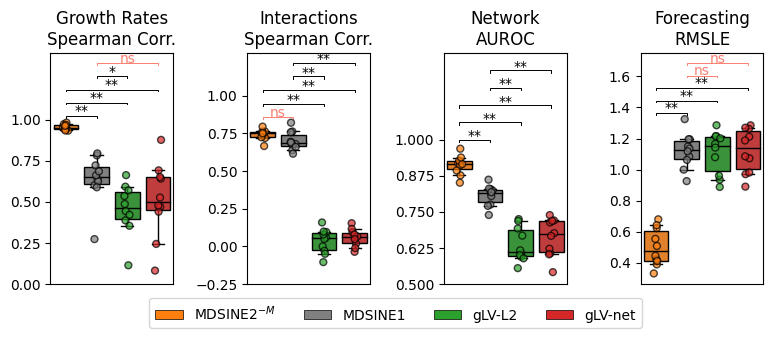

In [30]:
figure_width=9.2
figure_height=3
data_dir=Path('../datasets/synthetic/output')
read_depth=25000

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# method_order = ['MDSINE2', 'MDSINE1', 'lra-elastic_net', 'glv-elastic_net', 'glv-ridge', 'glv-ra-elastic_net', 'glv-ra-ridge']
method_order = ['MDSINE2', 'MDSINE1', 'glv-ridge', 'glv-elastic_net']
method_label = {
    'MDSINE2': 'MDSINE$2^{-M}$',
    'MDSINE1': 'MDSINE1',
    'glv-elastic_net': 'gLV-net',
    'glv-ridge': 'gLV-L2'
}
color_palette = {
    'MDSINE2': 'tab:orange',
    'MDSINE1': 'gray',
    'glv-elastic_net': default_colors[3],
    'glv-ridge': default_colors[2]
    # method: c for method, c in zip(method_order, default_colors)
}

fig = plt.figure(figsize=(figure_width, figure_height))
axes = render_all(
    fig,
    data_dir,
    method_order,
    color_palette,
    read_depth=read_depth
)
axes[0].set_yticks(np.linspace(0., 1., 5))
axes[0].set_ylabel('')
axes[0].set_title("Growth Rates\nSpearman Corr.")
axes[1].set_yticks(np.linspace(-0.25, 1., 6))
axes[1].set_ylabel('')
axes[1].set_title("Interactions\nSpearman Corr.")
axes[2].set_ylabel('')
axes[2].set_title("Network\nAUROC")
axes[3].set_ylabel('')
axes[3].set_title("Forecasting\nRMSLE")

lgd = draw_legend(fig, method_order, method_label, color_palette)

plt.tight_layout()
plt.savefig("plots/synthetic.pdf", bbox_inches='tight')